In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

``Data loading``

In [2]:
df_arrivals = pd.read_csv('../data/df_arrivals.csv')
df_departures = pd.read_csv('../data/df_departures.csv')
df_low_cost = pd.read_csv('../data/Low_Cost_Airlines.csv')
df_international_airports = pd.read_csv("../data/List_of_international_airports_by_country.csv")


plt.style.use("ggplot")

In [3]:
df_arrivals.shape, df_departures.shape, df_low_cost.shape

((77577, 20), (77577, 20), (179, 1))

In [4]:
def get_nan_rows(df):
    null_df = [df[df[column].isna()] for column in df.columns]
    stats_df = [(column, df[column].isna().sum(), (df[column].isna().sum() / df.shape[0]) * 100) for column in df.columns]
    stats_df = pd.DataFrame(stats_df, columns=["column", "nan_count", "nan_percentage"])
    return null_df, stats_df


def plot_nan_percentage_camembert(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    plt.pie(stats_df["nan_percentage"], labels=stats_df["column"], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    plt.show()

    return stats_df

def plot_nan_percentage(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    sns.barplot(x="nan_percentage", y="column", data=stats_df, orient="h")
    plt.title(title)
    plt.show()

    return stats_df

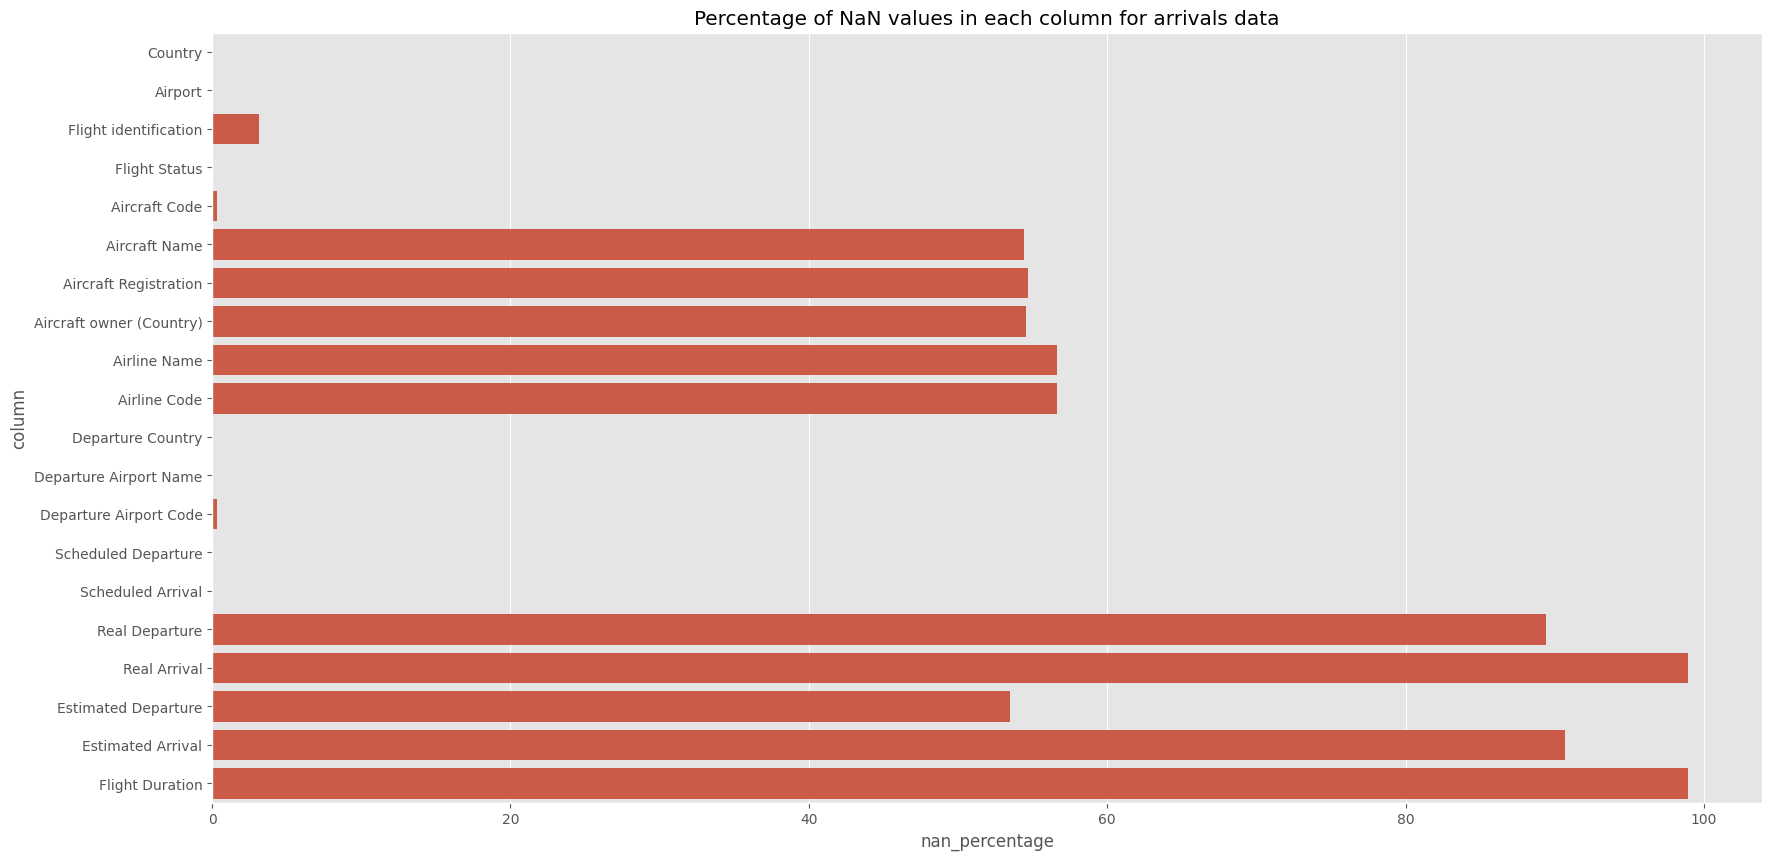

In [5]:
stats_df_arr = plot_nan_percentage(df_arrivals, "Percentage of NaN values in each column for arrivals data")

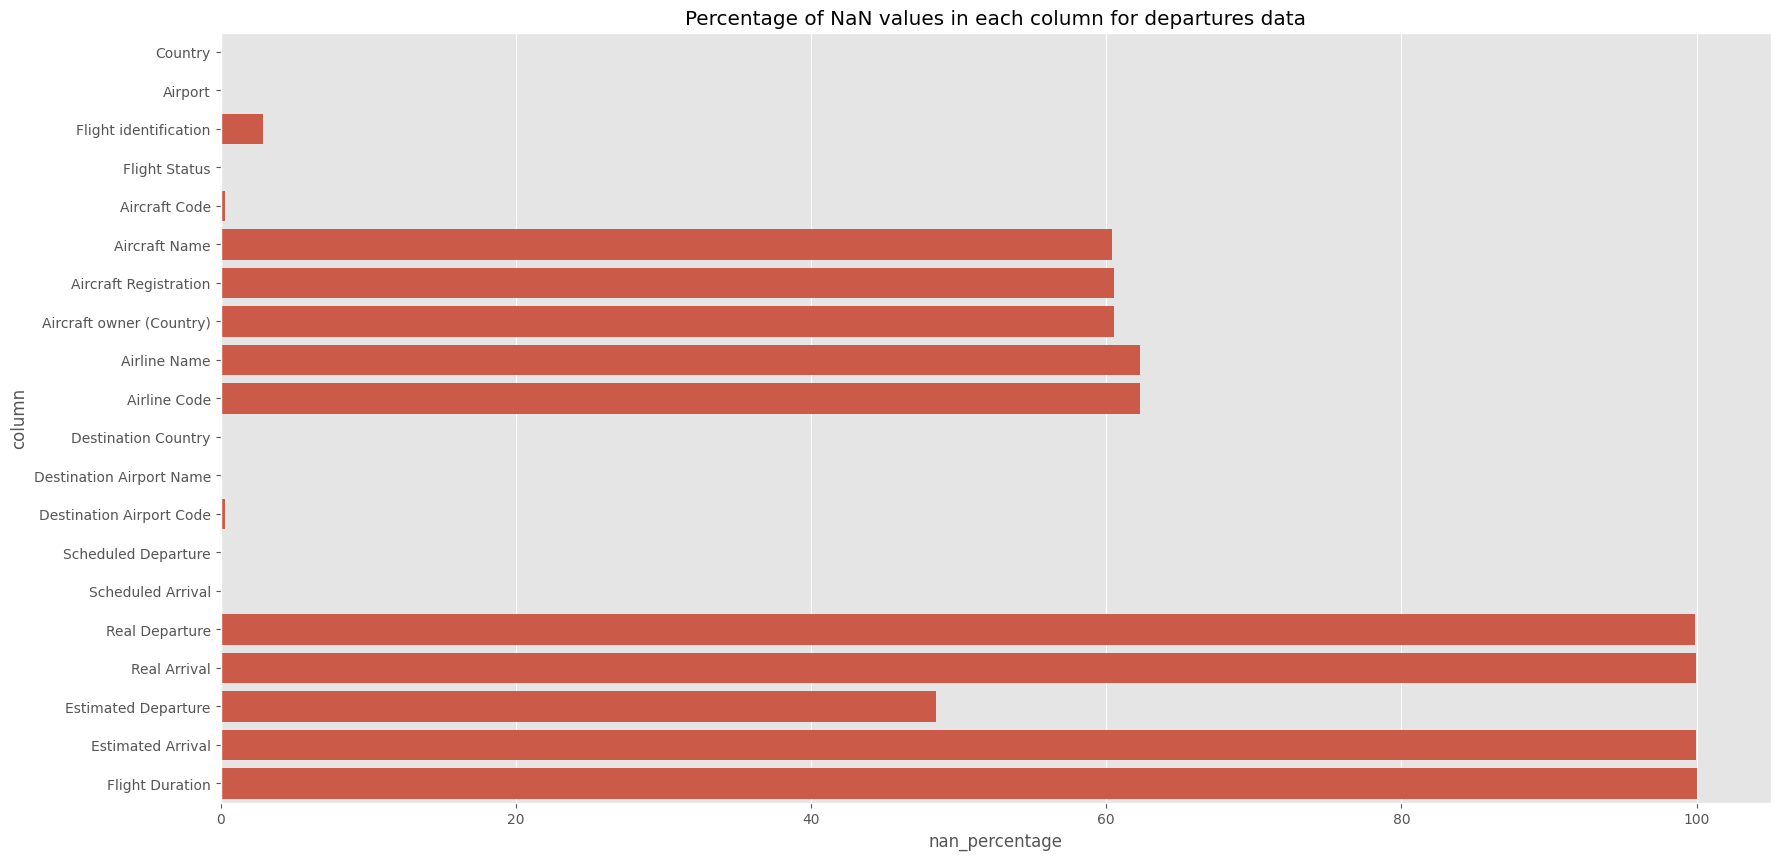

In [6]:
stats_df_dep = plot_nan_percentage(df_departures, "Percentage of NaN values in each column for departures data")

``Data cleaning``
- Nous allons retirer les colonnes avec beaucoup de valeurs manque + de 60%

In [7]:
df_arrivals_cleaned = df_arrivals[pd.notna(df_arrivals["Airline Name"])]
df_departures_cleaned = df_departures[pd.notna(df_departures["Airline Name"])]

df_arrivals_cleaned.shape, df_departures_cleaned.shape, df_low_cost.shape

((33643, 20), (29259, 20), (179, 1))

In [8]:
columns_to_drop = stats_df_arr[stats_df_arr["nan_percentage"] > 60]["column"].values
df_arrivals_cleaned = df_arrivals_cleaned.drop(columns=columns_to_drop)

In [9]:
columns_to_drop = stats_df_dep[stats_df_dep["nan_percentage"] > 65]["column"].values
df_departures_cleaned = df_departures_cleaned.drop(columns=columns_to_drop)

``Data seperation between low-cost and high-cost company``
- On récupère les companies low-cost et fullservice séparemment

In [10]:
def separate_df(df):
    df_low_cost_service = df[df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    df_full_service = df[~df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    return df_low_cost_service, df_full_service

df_arrivals_low_cost, df_arrivals_full_service = separate_df(df_arrivals_cleaned)
df_departures_low_cost, df_departures_full_service = separate_df(df_departures_cleaned)

In [11]:
df_arrivals_low_cost.shape, df_arrivals_full_service.shape, df_departures_low_cost.shape, df_departures_full_service.shape

((8034, 16), (25609, 16), (7444, 16), (21815, 16))

- On vérifie aussi la répartition des valeurs manquantes

<Axes: title={'center': 'Number of NaN values per column for low cost airlines arrivals data'}>

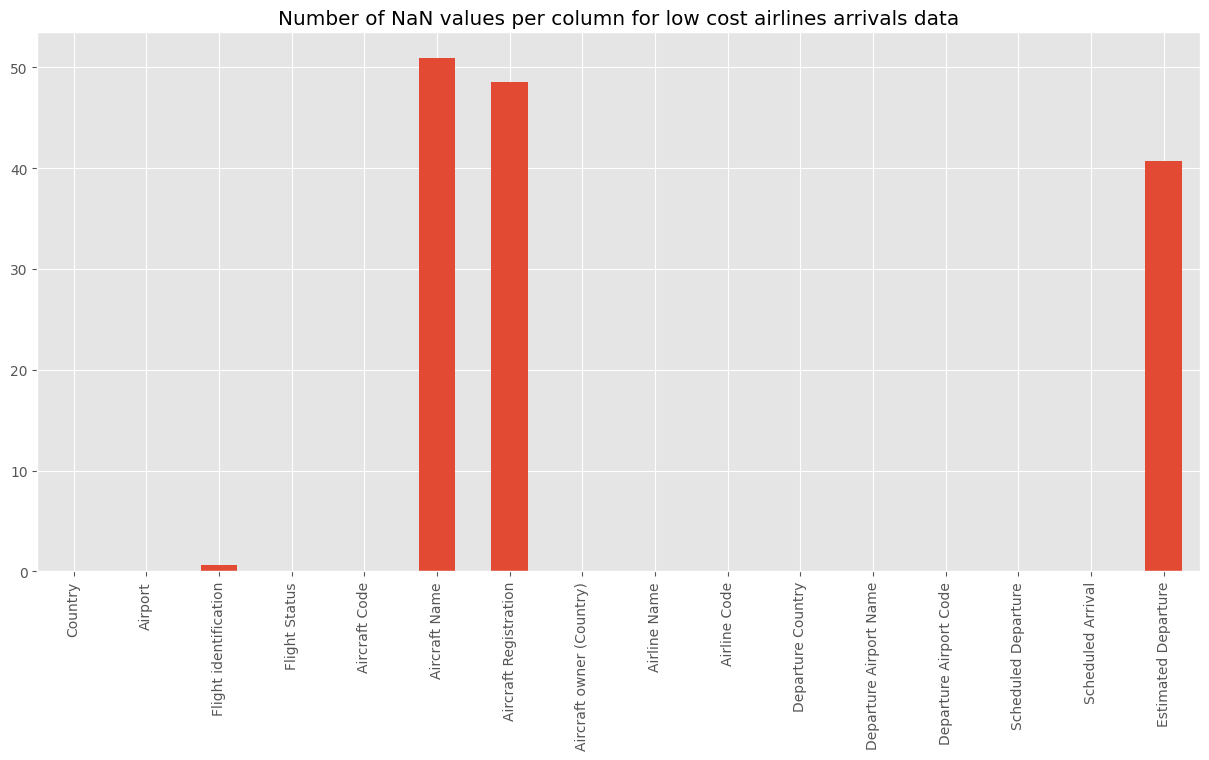

In [12]:
def convert_to_percentage(x):
    return (x / df_arrivals_low_cost.shape[0]) * 100

df_arrivals_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for high cost airlines arrivals data'}>

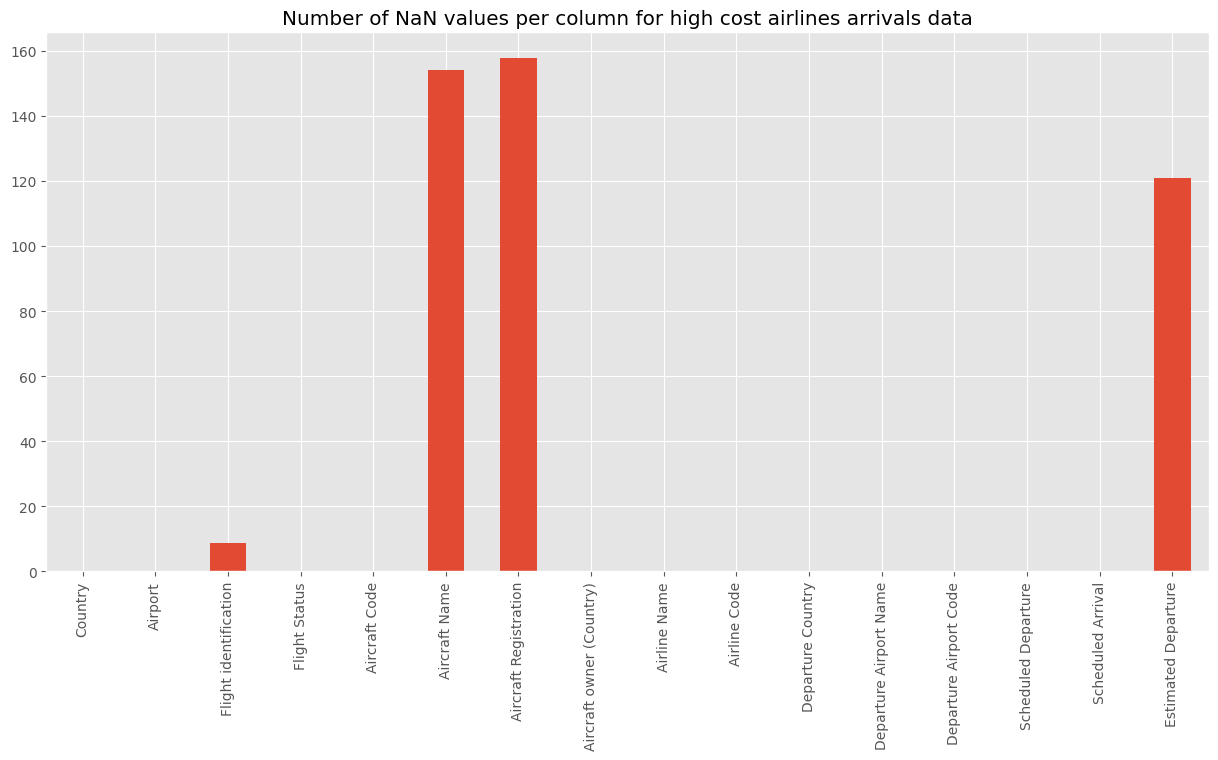

In [13]:
df_arrivals_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for high cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for low cost airlines departures data'}>

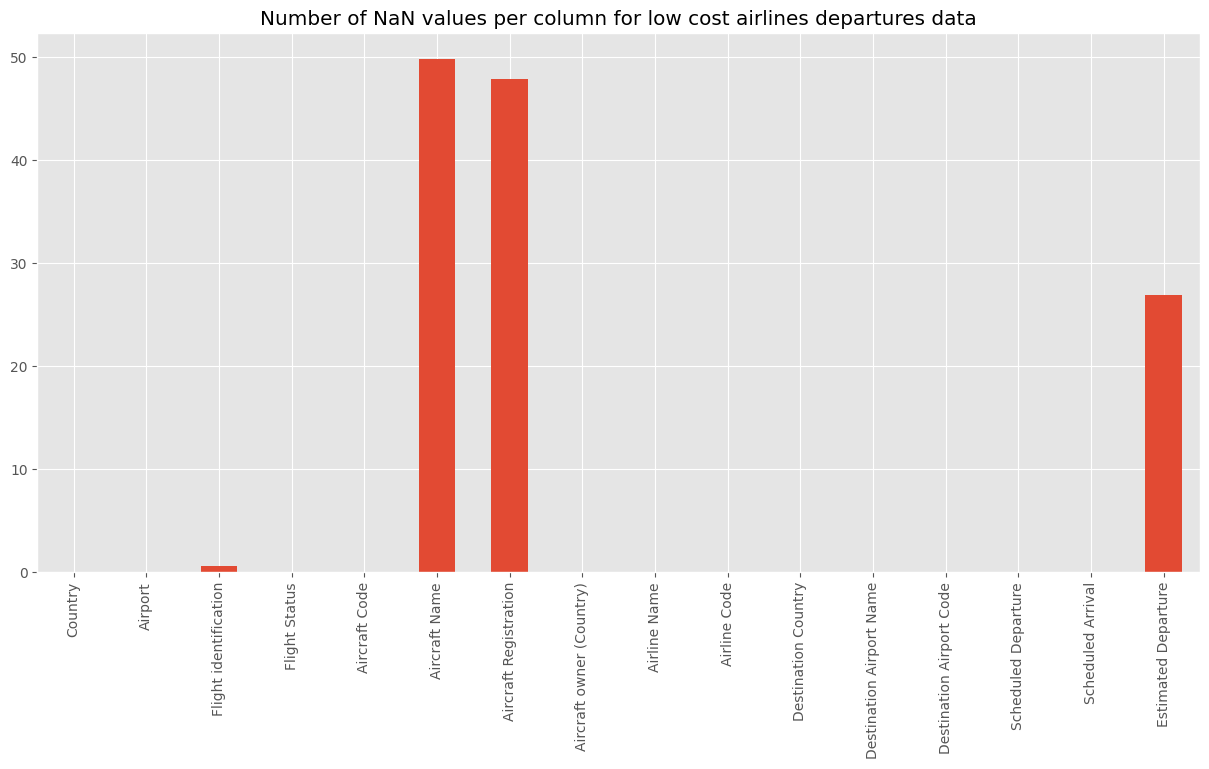

In [14]:
df_departures_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines departures data")

<Axes: title={'center': 'Number of NaN values per column high low cost airlines departures data'}>

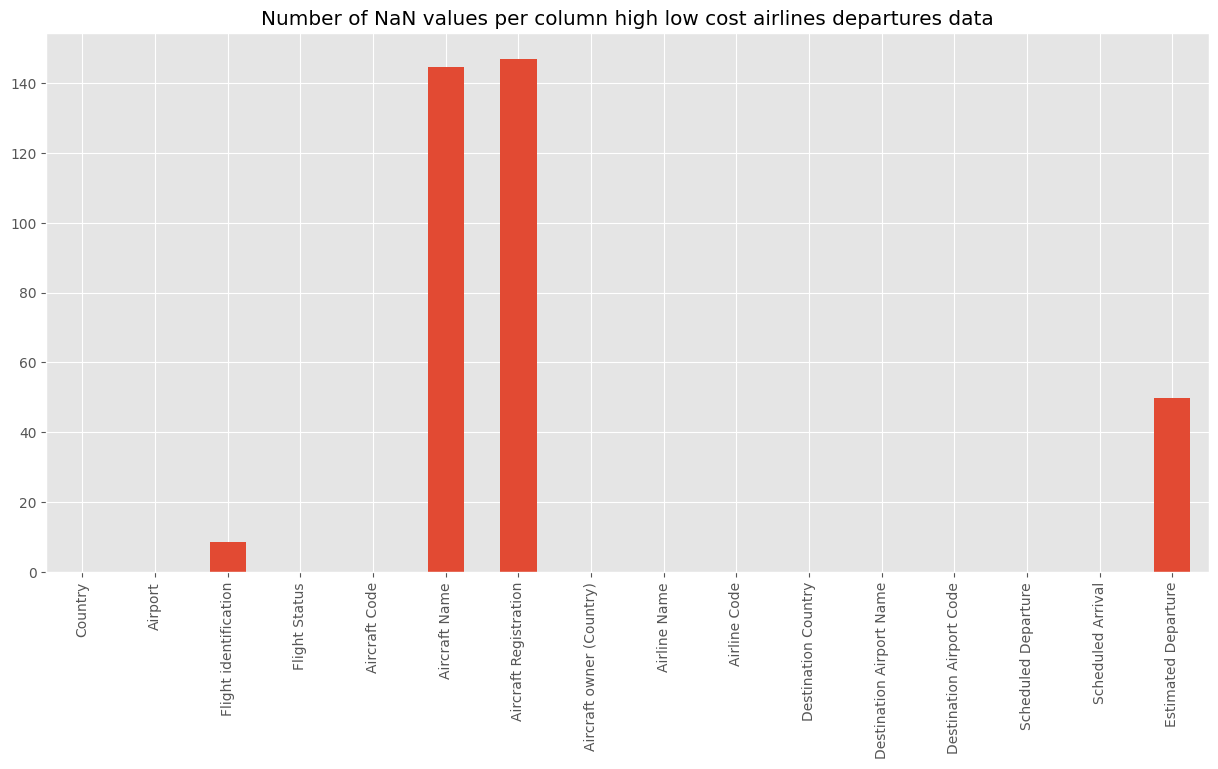

In [15]:
df_departures_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column high low cost airlines departures data")

``Number of low cost company vs full service`` 
- On constate clairement que en générale on a bien plus de companies full-service que low-cost (3x +)

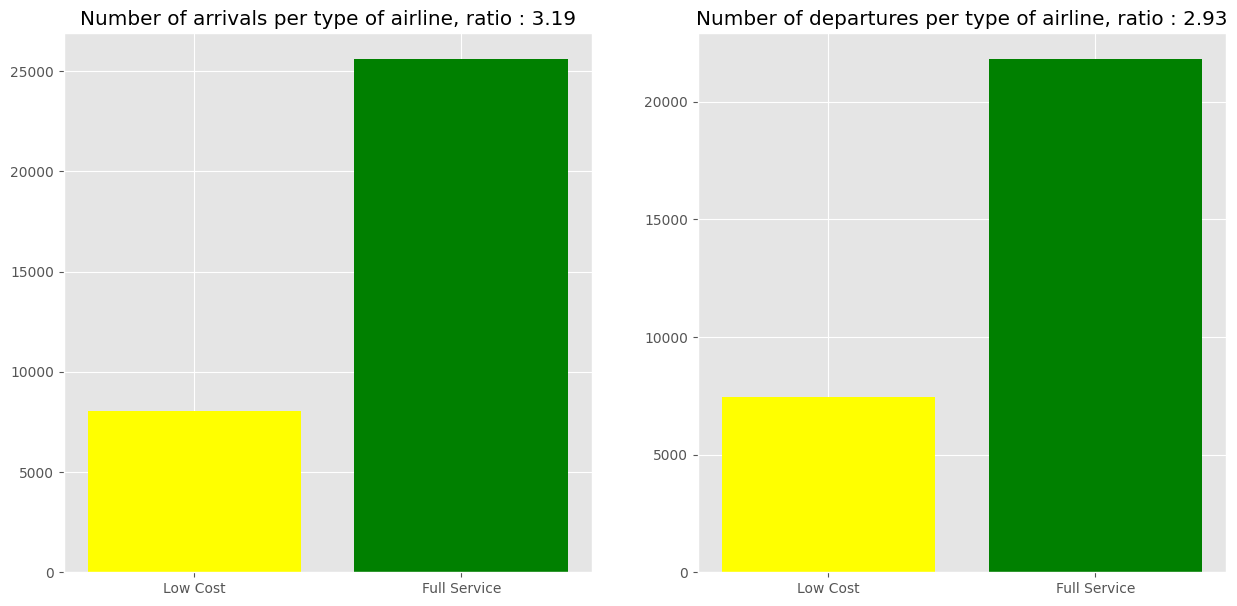

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.bar(["Low Cost", "Full Service"], [df_arrivals_low_cost.shape[0], df_arrivals_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of arrivals per type of airline, ratio : {df_arrivals_full_service.shape[0] / df_arrivals_low_cost.shape[0]:.2f}")
plt.subplot(1, 2, 2)
plt.bar(["Low Cost", "Full Service"], [df_departures_low_cost.shape[0], df_departures_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of departures per type of airline, ratio : {df_departures_full_service.shape[0] / df_departures_low_cost.shape[0]:.2f}")
plt.show()

``Type of plane``
- Pour celà nous allons d'abord join les datasets sur l'attribut d'index pour pouvoir bien comparer

In [17]:
def join_dataset(df_arrivals, df_departures):
    df_matched = df_arrivals.join(df_departures, how='inner', lsuffix='_arr', rsuffix='_dep')
    columns_to_drop = [col for col in df_matched.columns if col.endswith('_dep') and col[:-4] + '_arr' in df_matched.columns]
    df_matched.drop(columns=columns_to_drop, inplace=True)
    df_matched.rename(columns=lambda x: x.replace('_arr', ''), inplace=True)
    return df_matched

df_matched_low_cost = join_dataset(df_arrivals_low_cost, df_departures_low_cost)
df_matched_full_service = join_dataset(df_arrivals_full_service, df_departures_full_service)

df_matched_low_cost.shape, df_matched_full_service.shape

((3137, 19), (13745, 19))

In [18]:
aircraft_low_cost = df_matched_low_cost.groupby("Aircraft Code").apply(len).sort_values(ascending=False)
aircraft_full_service = df_matched_full_service.groupby("Aircraft Code").apply(len).sort_values(ascending=False)

- Tout les codes d'avions

In [19]:
all_aircraf_code = list(set(df_arrivals["Aircraft Code"].unique()).union(df_departures["Aircraft Code"].unique()))

In [20]:
aircraft_low_cost_complete = aircraft_low_cost.reindex(all_aircraf_code, fill_value=0)
aircraft_full_service_complete = aircraft_full_service.reindex(all_aircraf_code, fill_value=0)
combined_aircraft_usage = pd.concat([aircraft_low_cost_complete, aircraft_full_service_complete], axis=1, keys=['Low Cost', 'Full Service'])

In [21]:
df_matched_low_cost.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A20N,515,10,IndiGo,343
A21N,224,18,IndiGo,146
A319,109,9,Allegiant Air,33
A320,643,18,AirAsia,101
A321,48,9,JetBlue Airways,14
A333,3,2,AirAsia X,2
A359,1,1,French Bee,1
A35K,1,1,French Bee,1
AT75,1,1,Firefly,1


In [22]:
df_matched_full_service.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A139,3,2,Offshore Helicopter Services,2
A20N,736,57,Azul Linhas Aereas,196
A21N,391,48,Wizz Air Malta,63
A306,28,5,European Air Transport,16
A310,2,1,ULS Airlines Cargo,2
...,...,...,...,...
SB20,2,1,Nyxair,2
SF34,96,8,Rex,49
SU95,15,4,Rossiya,9


In [23]:
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False)

,Low Cost,Full Service
Aircraft Code,,
A320,643,1655
B738,530,1386
A20N,515,736
B737,429,260
B38M,312,423
...,...,...
75C,0,0
GLF6,0,0
BNT,0,0


- On constate clairement que les avions les plus utilisés sont commun au deux type de companies: 
    - A320, B738, A20N
- Cependant pendant que les companies low-cost conitnues d'utiliser que des avions moyen-courrier: 
    - B737, B38M
- Les companies full-service utilise beaucoup plus les avions long-courrier : 
    - A333, B788, B772, A359, B789
- Tres tres peu d'avion long courrier sont utilisé par les companies low-cost : 
    'Air Europa', 'Jetstar', 'Thai AirAsia X', 'Scoot', 'AirAsia X',
    'Lion Air', 'Jin Air'

<Figure size 3000x1200 with 0 Axes>

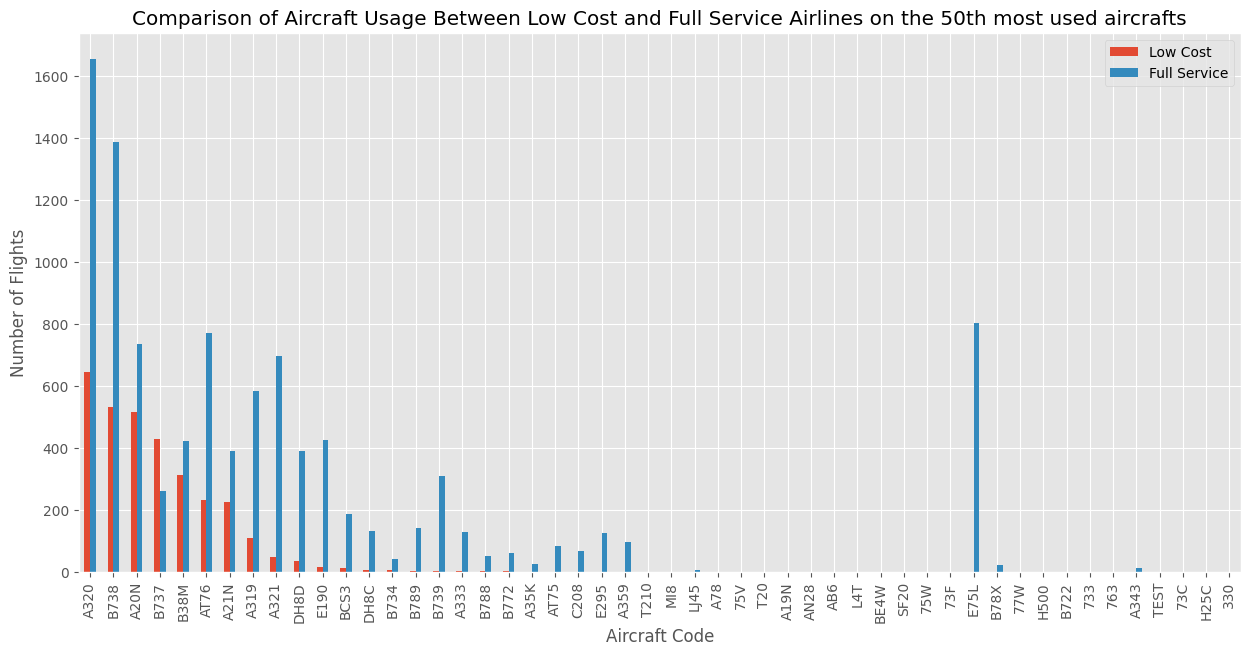

In [24]:
plt.figure(figsize=(30,12))
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False).iloc[:50].plot(kind="bar", figsize=(15, 7), title="Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 20th most used aircrafts")
plt.xlabel("Aircraft Code")
plt.ylabel("Number of Flights")
plt.title("Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 50th most used aircrafts")
plt.legend()
plt.xticks(rotation=90)
plt.show()

- Companies low-cost qui utilise des avions long-courrier
- Y'en a que 7, contre 90 pour les companies full-services

In [25]:
long_range_code = ["B789","B788","B772","A333"]

companies_that_use_long_range = df_arrivals_low_cost[df_arrivals_low_cost["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()
companies_that_use_long_range_full_service = df_arrivals_full_service[df_arrivals_full_service["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()

print("Number of low cost airlines that use long range aircrafts : ", len(companies_that_use_long_range))
print("Number of full service airlines that use long range aircrafts : ", len(companies_that_use_long_range_full_service))

Number of low cost airlines that use long range aircrafts :  7
Number of full service airlines that use long range aircrafts :  90


- En générale les companies low-cost déservent moins d'aeroport internationaux que les companies full-service

``Aéroport de départ et deservies par companies low-cost vs full service``

- En terme de chiffre pure, les companies full-service deservent bien plus d'aeroport internationnaux que les companies low-cost
- Même constat pour les aéroport de départ

In [26]:
def preprocess(airport):
    airport = airport.lower()
    airport = airport.strip()
    return airport

In [100]:
def calculate_number_of_airport_arrivals(df):
    number_of_airport_arrivals = len(df["Airport"].unique())
    number_of_international_airport_arrivals = len(set(df["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))
    print("On the ", number_of_airport_arrivals, " airports that low cost airlines arrive from, ", number_of_international_airport_arrivals, " are international airports")
    print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

print("[ARRIVALS]")
calculate_number_of_airport_arrivals(df_arrivals_low_cost)
calculate_number_of_airport_arrivals(df_arrivals_full_service)
print()
print("[DEPARTURES]")
calculate_number_of_airport_arrivals(df_departures_low_cost)
calculate_number_of_airport_arrivals(df_departures_full_service)

[ARRIVALS]
On the  961  airports that low cost airlines arrive from,  299  are international airports
Ratio : 31.113423517169615%
On the  2089  airports that low cost airlines arrive from,  479  are international airports
Ratio : 22.929631402584967%

[DEPARTURES]
On the  821  airports that low cost airlines arrive from,  239  are international airports
Ratio : 29.11084043848965%
On the  1874  airports that low cost airlines arrive from,  438  are international airports
Ratio : 23.372465314834578%


``Destination deservies par les companies low-cost``

- Concernant les destinations, les companies low-cost deservent moins de destination que les companies fsull-service, voir la map ci-dessous
- Exemple de destination non deservie par les companies low-cost : Nigeria, Uruguay, Iran etc... 

In [101]:
def calculate_number_of_dest(df):
    all_dest = df["Destination Country"].unique()
    print(f"{len(all_dest)} unique destination")

calculate_number_of_dest(df_departures_low_cost)
calculate_number_of_dest(df_departures_full_service)

104 unique destination
183 unique destination


C:\Users\halim\AppData\Local\Temp\ipykernel_4176\2511726721.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Counries not deserved by low cost companies : {'Jordan', 'Northern Mariana Islands', 'Uruguay', 'Guadeloupe', 'Eritrea', 'Nigeria', 'Mayotte', 'Bolivia', 'Kyrgyzstan', 'Palau', 'New Caledonia', 'Micronesia', 'Mongolia', 'Georgia', 'Angola', 'Iran', 'Benin', 'Tanzania', 'Malawi', 'Guinea', 'Saint Vincent And The Grenadines', 'Ghana', 'Kosovo', 'Sao Tome And Principe', 'Marshall Islands', 'Libya', 'Liberia', 'Namibia', 'Cook Islands', 'Hong Kong', 'Burkina Faso', 'French Guiana', 'Moldova', 'Suriname', 'Virgin Islands British', 'Mauritius', 'Congo', 'Greenland', 'Comoros', 'Lesotho', 'Reunion', 'Guernsey', 'Sierra Leone', 'Martinique', 'Kuwait', 'French Polynesia', 'Chad', 'Tonga', 'Solomon Islands', 'American Samoa', 'Uganda', 'South Sudan', 'Rwanda', 'Turkmenistan', 'Cocos (Keeling) Islands', 'Mali', 'Papua New Guinea', 'Cameroon', 'Democratic Republic Of The Congo', 'Eswatini', 'Burundi', 'Dominica', 'Ethiopia', 'Tuvalu', 'Gambia', 'Madagascar', 'Botswana', 'Bermuda', 'Seychelles', 'C

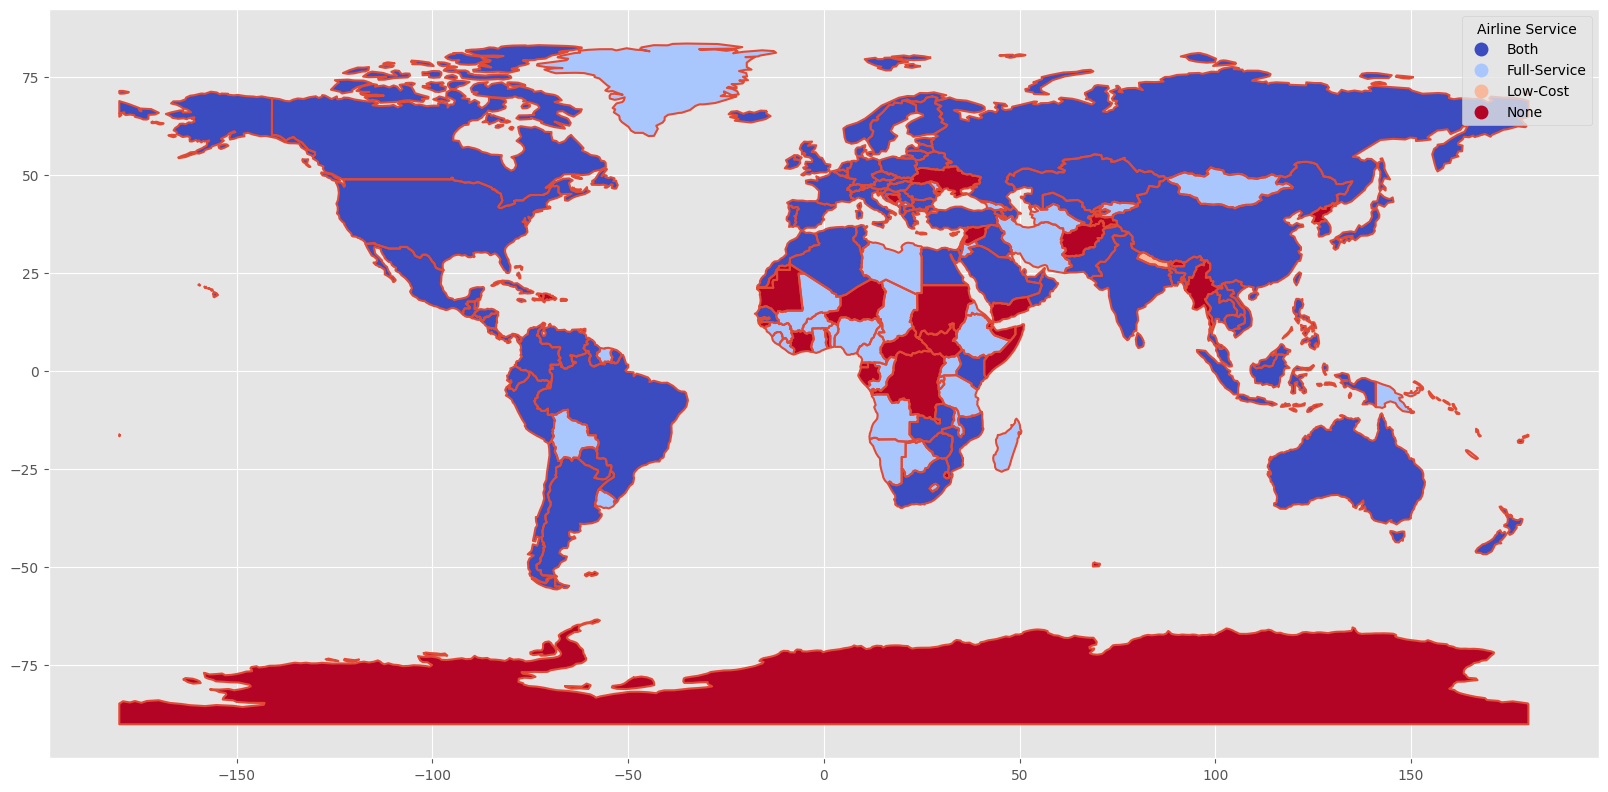

In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt

def preprocess_usa(country):
    if(country == "United States"):
        return "United States of America"
    return country

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries_full_service = df_departures_full_service["Country"].apply(preprocess_usa).unique()
countries_low_cost = df_departures_low_cost["Country"].apply(preprocess_usa).unique()
print(f"Counries not deserved by low cost companies : {set(countries_full_service)-set(countries_low_cost)}")
# Create a new column in the world dataframe to represent the airline service
world['airline_service'] = 'None'
world.loc[world['name'].isin(countries_full_service), 'airline_service'] = 'Full-Service'
world.loc[world['name'].isin(countries_low_cost), 'airline_service'] = 'Low-Cost'

# For countries served by both, we adjust the entry accordingly
world.loc[world['name'].isin(set(countries_full_service).intersection(set(countries_low_cost))), 'airline_service'] = 'Both'

# Plottings
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
world.boundary.plot(ax=ax)
world.plot(column='airline_service', ax=ax, legend=True,
           legend_kwds={'title': 'Airline Service'},
           cmap='coolwarm')
plt.show()


``Fréquence de vol de companies low-cost vs full-service``

- On constate que les companies avec le plus de fréquence de vols, sont 2 companies low-cost: 
    - Southwest Airline, et IndiGO
- On constate clairement que la mediane, les quartiles, et la moyenne sont bien plus elevé pour les companies low-cost que full-service

In [147]:
companies_low_cost_freq = df_matched_low_cost.groupby("Airline Name").apply(len).sort_values(ascending=False)
companies_full_service_freq = df_matched_full_service.groupby("Airline Name").apply(len).sort_values(ascending=False)

companies_low_cost_freq = companies_low_cost_freq.to_frame(name='Frequency')
companies_full_service_freq = companies_full_service_freq.to_frame(name='Frequency')

companies_low_cost_freq['Airline Service'] = 'Low-Cost'
companies_full_service_freq['Airline Service'] = 'Full-Service'

all_comp_freq = pd.concat([companies_low_cost_freq, companies_full_service_freq], axis=0)
all_comp_freq = all_comp_freq.reset_index()

In [151]:
print("Top 10 companies with more frequency : ")
all_comp_freq.head(10)

Top 10 companies with more frequency : 


,Airline Name,Frequency,Airline Service
0,Southwest Airlines,829,Low-Cost
1,IndiGo,725,Low-Cost
55,Delta Air Lines,675,Full-Service
54,SkyWest Airlines,675,Full-Service
56,American Airlines,665,Full-Service
57,Azul Linhas Aereas,600,Full-Service
58,United Airlines,547,Full-Service
59,China Eastern Airlines,380,Full-Service
60,Air New Zealand,338,Full-Service
61,LATAM Brasil,315,Full-Service


In [156]:
pd.concat([companies_low_cost_freq.describe(), companies_full_service_freq.describe()], axis=1, keys=["Low cost", "Full service"])

,Low cost,Full service
,Frequency,Frequency
count,54.000000,589.000000
mean,58.092593,23.336163
std,148.368901,69.784891
min,1.000000,1.000000
25%,2.000000,1.000000
50%,10.500000,3.000000
75%,53.500000,15.000000
max,829.000000,675.000000


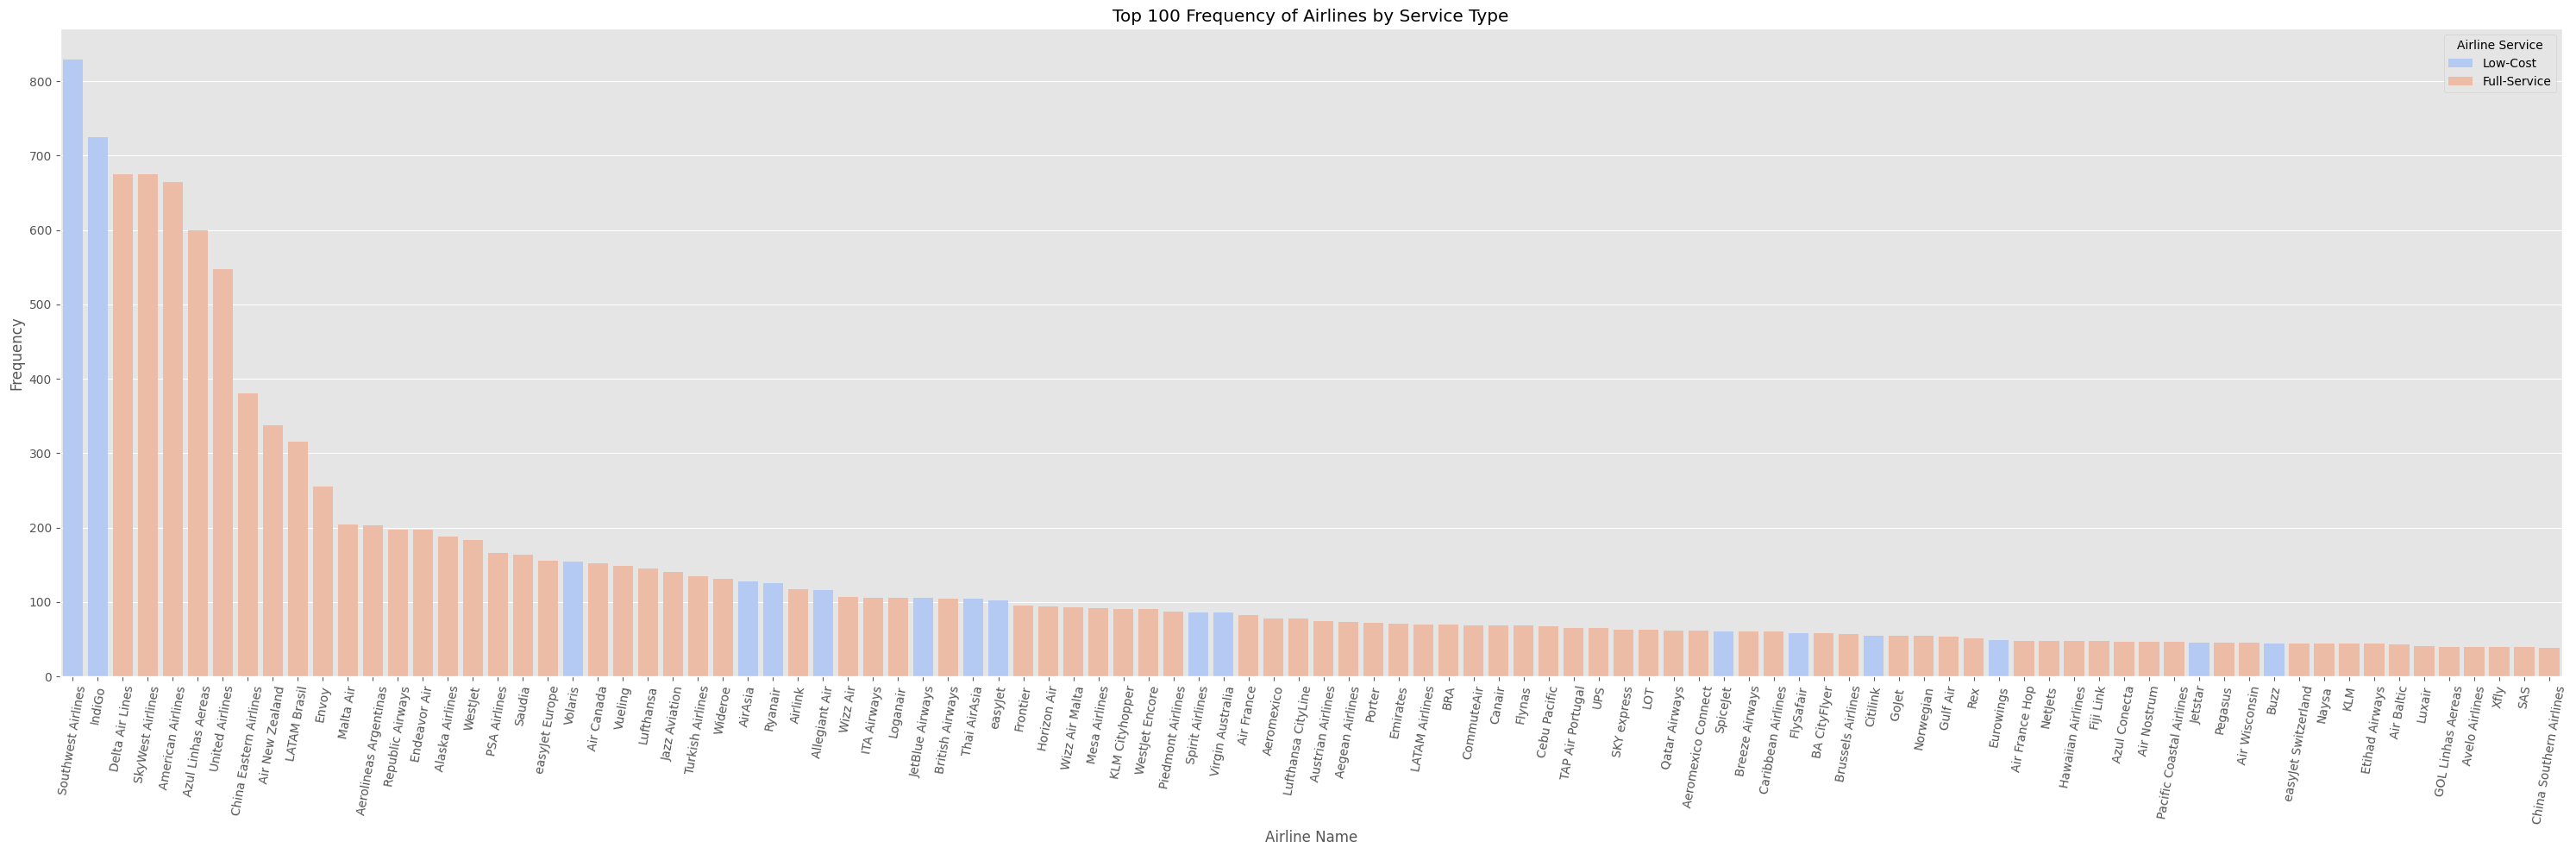

In [159]:
all_comp_freq.sort_values(by='Frequency', ascending=False, inplace=True)

plt.figure(figsize=(30, 10))
ax = sns.barplot(data=all_comp_freq.head(100), x='Airline Name', y='Frequency', hue='Airline Service', palette='coolwarm')

ax.set_title('Top 100 Frequency of Airlines by Service Type')
ax.set_xlabel('Airline Name')
ax.set_ylabel('Frequency')
plt.xticks(rotation=80) 
plt.legend(title='Airline Service')

plt.tight_layout()
plt.show()